<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/labs/lab_10/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [ ]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [ ]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [ ]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281_2022/main/labs/lab_10/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [ ]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


<function matplotlib.pyplot.show(*args, **kw)>

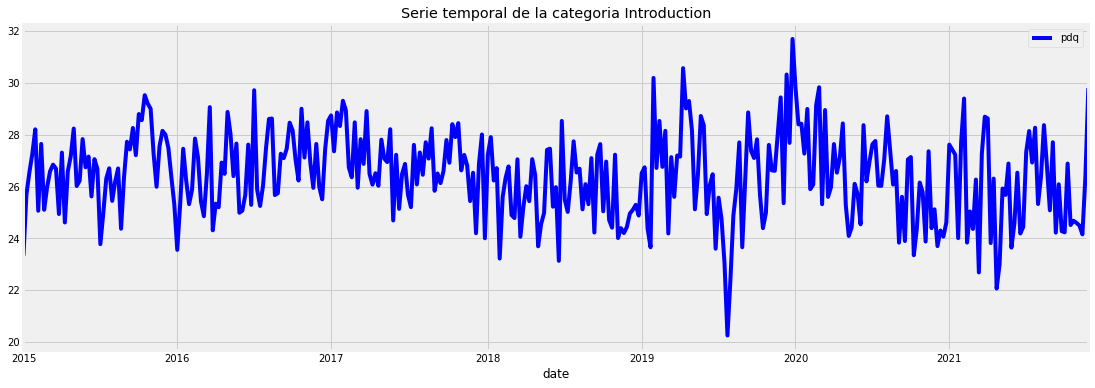

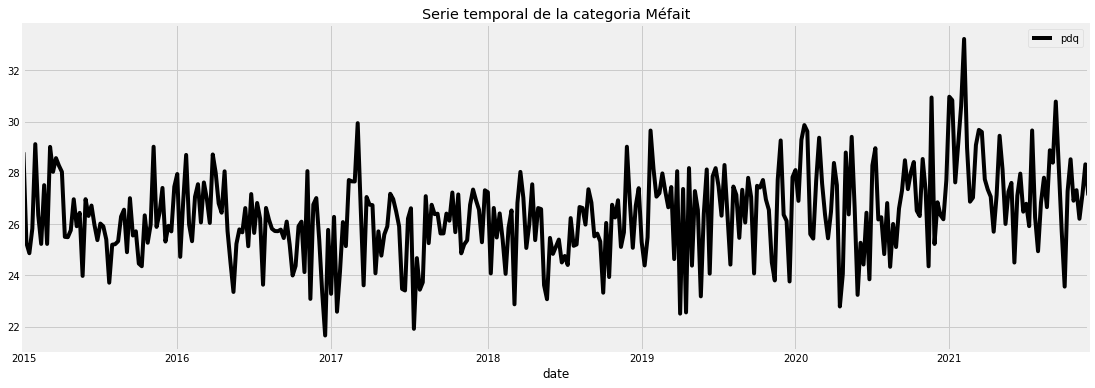

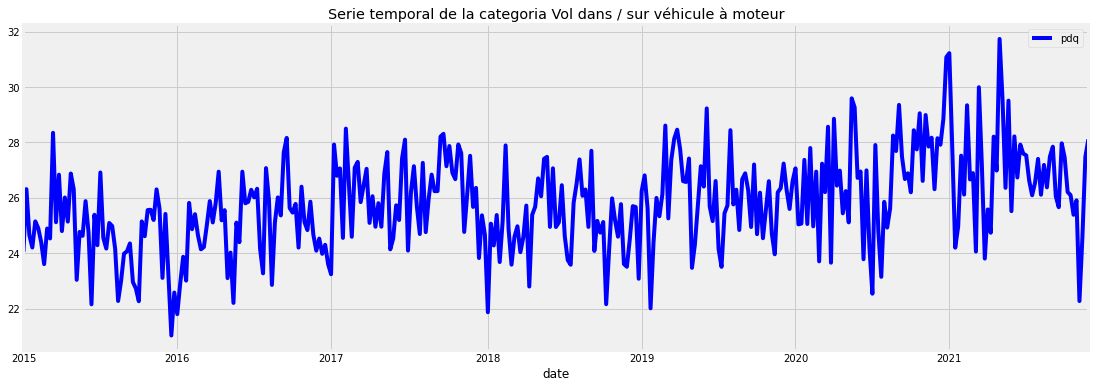

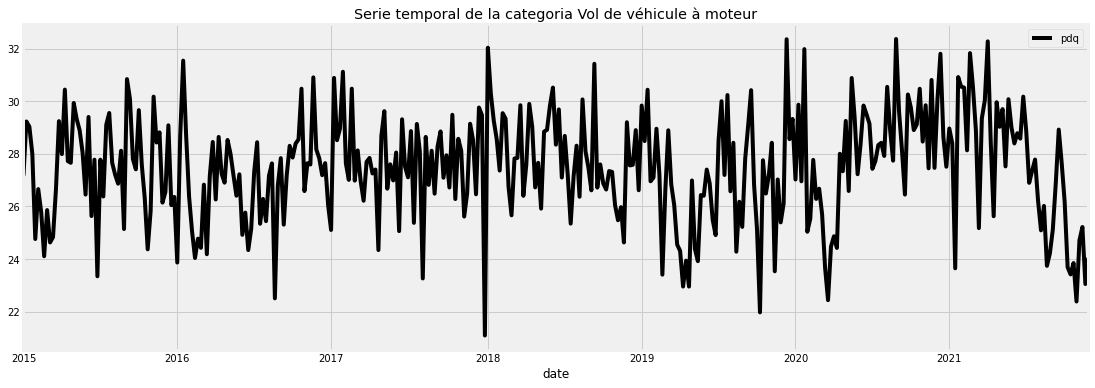

In [ ]:
y_s1.plot(figsize=(17,6), color= 'blue')
plt.title('Serie temporal de la categoria Introduction')
plt.show

y_s2.plot(figsize=(17,6), color= 'black')
plt.title('Serie temporal de la categoria Méfait')
plt.show

y_s3.plot(figsize=(17,6), color= 'blue')
plt.title('Serie temporal de la categoria Vol dans / sur véhicule à moteur')
plt.show

y_s4.plot(figsize=(17,6), color= 'black')
plt.title('Serie temporal de la categoria Vol de véhicule à moteur')
plt.show

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realizar un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [ ]:
# se trabajara con la serie temporal y_s4

y_s4.describe()

,pdq
count,361.000000
mean,27.460034
std,2.048360
min,21.093750
25%,26.283951
50%,27.581081
75%,28.893333
max,32.365591


Descomposicion aditiva de la serie temporal de la categoria Vol de véhicule à moteur


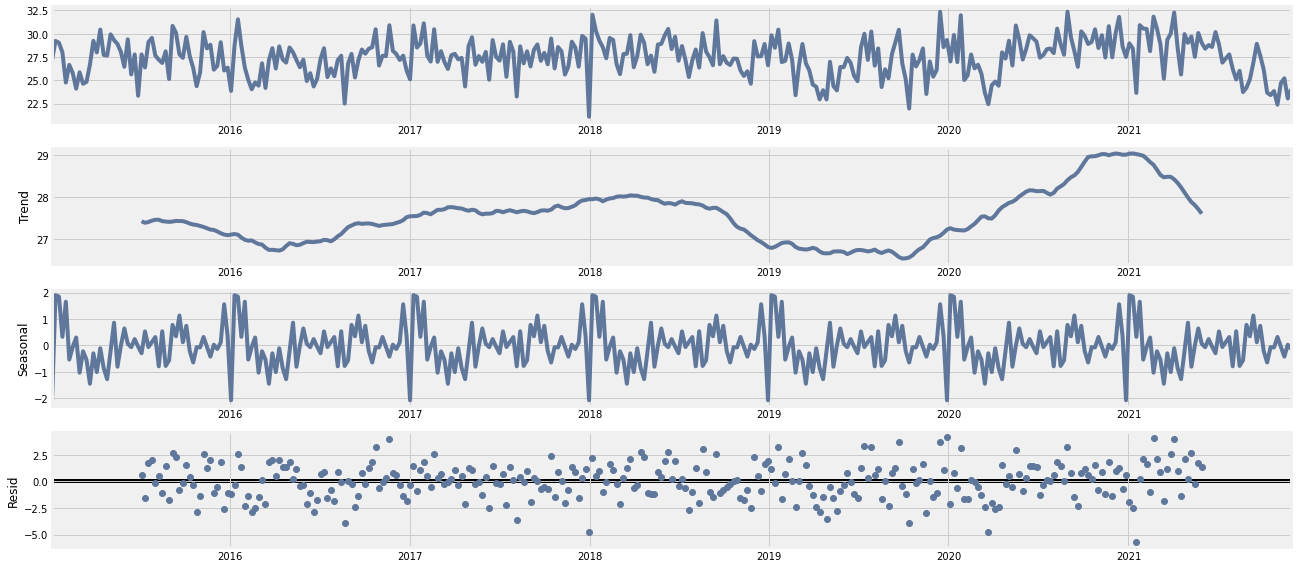

Descomposicion multiplicativa de la serie temporal de la categoria Vol de véhicule à moteur


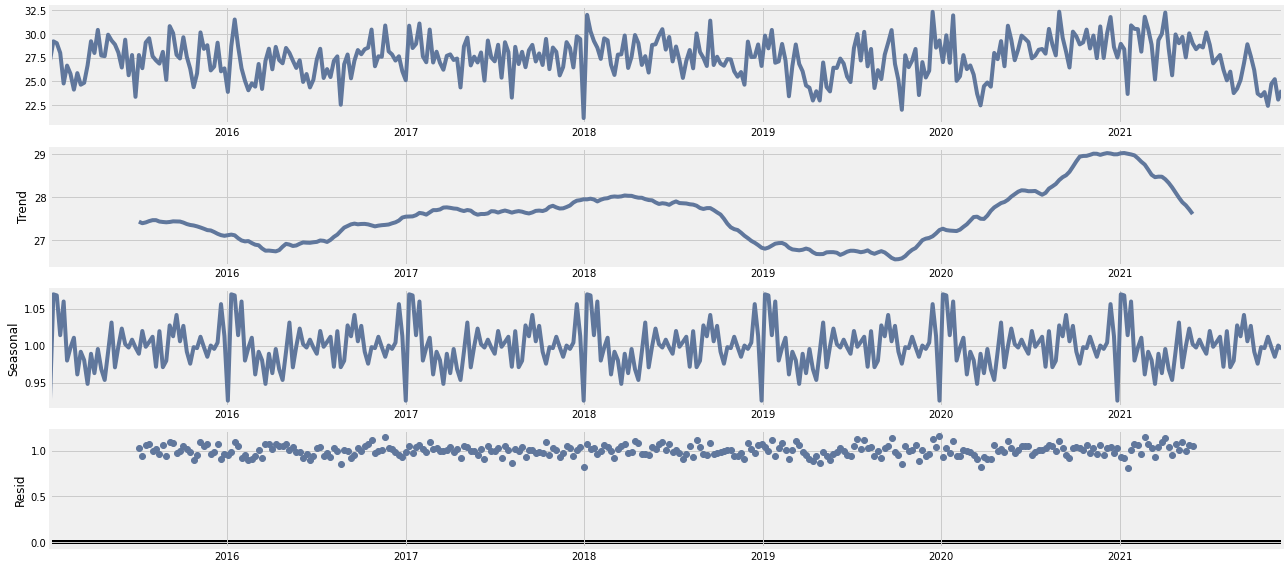

In [ ]:
#veamos una descomposicion aditiva y multiplicativo de esta serie
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s4, model='additive')
fig = decomposition.plot()
print("Descomposicion aditiva de la serie temporal de la categoria Vol de véhicule à moteur")
plt.show()

decomposition = sm.tsa.seasonal_decompose(y_s4, model='multiplicative')
fig = decomposition.plot()
print("Descomposicion multiplicativa de la serie temporal de la categoria Vol de véhicule à moteur")
plt.show()

Se logra ver que en ambas descomposiciones de la serie temporal y_s4 se obtienen graficos parecidos de tendencia y estacionariedad, donde se logra ver que no se pesenta una tendencia lineal en esta serie; además, existe una estacionariedad por año, donde se logra ver que no se parece a alguna curva suave, alcanza su maximo a inicios del año, alcanza su minimo a fines del año y tiene muchas subidas y bajadas en el año. Por ultimo, en el grafico de error obtenido por la descomposicion aditiva se logra ver que el error oscila entre -5 y 5, mientras que en el grafico de error obtenido por la descomposicion multiplicativa se logra ver que el error oscila entre 0 y 1,25. Se logra ver que el error oscila sobre el valor 0 en el grafico de descomposicion aditiva, pero tendriamos que ver si posee una varianza constante e igual a 1 para ver si corresponde a ruido blanco. Tambien, se logra ver que el error oscila sobre el valor 1 en el grafico de descomposicion multiplicativa, por lo tanto no corresponde a ruido blanco segun esta descomposicion.

Al ver el grafico de la serie temporal y_s4, se podria decir que no es una serie estacionaria, pues no presneta una varainza constante, sus valores varian en el conjunto acotado [21, 33] y sus oscilaciones son erraticas. Veamos graficos ACF/PACF y la prueba Dickey-Fuller para ver si podemos afirmar esto.

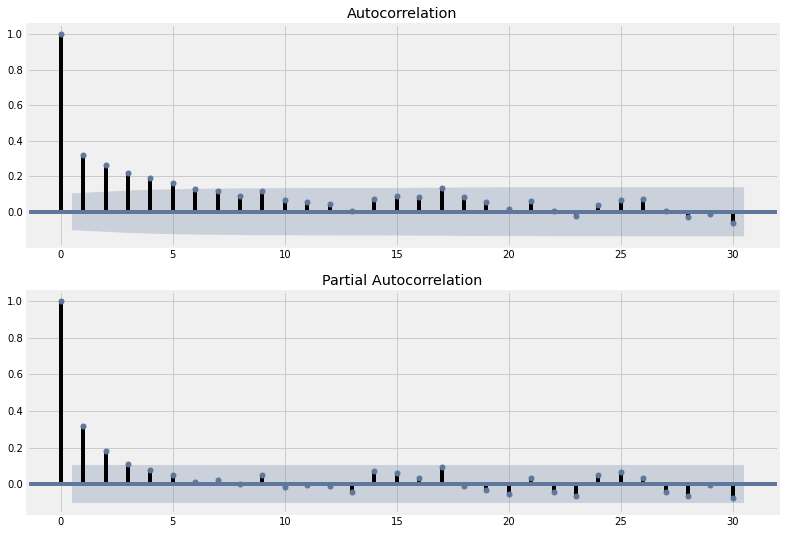

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(y_s4, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(y_s4, ax=pyplot.gca(), lags = 30)
pyplot.show()

Se logra ver que los graficos ACF/PACF son parecidos y decae a 0 relativamanete rapido, por lo tanto, se puede decir que la serie temporal y_s4 podria ser estacionaria.

In [ ]:
from statsmodels.tsa.stattools import adfuller

#test Dickey-Fulle:
print ('Resultados del test de Dickey-Fuller:')
dftest = adfuller(y_s4, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Resultados del test de Dickey-Fuller:
Test Statistic                -6.097602e+00
p-value                        1.001312e-07
#Lags Used                     3.000000e+00
Number of Observations Used    3.570000e+02
dtype: float64


Dado que el p-value es aproximadamente 0, indica que esta serie presenta estacionariedad. Por lo tanto, la serie temporal y_s4 es estacionaria.

In [ ]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [ ]:
datos_params= []

for parametros in params:
    try:
        sarima_model= SarimaModels(parametros)
        df_metrics = sarima_model.metrics(y_s4,target_date)
        datos_params.append(df_metrics)
    except:
        pass

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [ ]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(datos_params)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,2.0715,6.0093,2.4514,0.0774,0.0770,0.0756,0.0746,0.0761,"SARIMA_(1,1,0)X(1,1,0,12)"
0,2.0806,5.9165,2.4324,0.0756,0.0753,0.0759,0.0729,0.0764,"SARIMA_(0,1,0)X(1,1,0,12)"
0,2.0941,6.3229,2.5145,0.0788,0.0784,0.0764,0.0759,0.0771,"SARIMA_(1,0,1)X(1,1,1,12)"
0,2.0957,6.3213,2.5142,0.0789,0.0784,0.0765,0.0760,0.0772,"SARIMA_(1,0,1)X(0,1,1,12)"
0,2.1406,6.7941,2.6066,0.0817,0.0811,0.0781,0.0786,0.0788,"SARIMA_(1,1,0)X(0,1,1,12)"
...,...,...,...,...,...,...,...,...,...
0,4.1728,21.4377,4.6301,0.1515,0.1496,0.1522,0.1461,0.1660,"SARIMA_(0,1,0)X(0,1,0,12)"
0,22.6225,576.9379,24.0195,0.8341,0.6687,0.8253,0.8042,1.6061,"SARIMA_(0,0,0)X(0,0,1,12)"
0,23.2817,585.8531,24.2044,0.8567,0.6902,0.8493,0.8260,1.6318,"SARIMA_(0,0,1)X(0,0,1,12)"
0,27.2142,748.4149,27.3572,0.9932,0.7814,0.9928,0.9579,1.9794,"SARIMA_(0,0,1)X(0,0,0,12)"


Se logra ver que con hiperparametros (1,1,0)X(1,1,012) se obtuvieron los menores resultados de las metricas mae y mape. Por lo tanto, estos son los mejores hiperparametros para modelo Sarima.

In [ ]:
param = [(1,1,0),(1,1,0,12)]
sarima =  SarimaModels(param)
model_fit = sarima.fit_model(y_s4,target_date)
best_model = sarima.df_testig(y_s4,target_date)
best_model.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,y,yhat
2021-01-03,28.961039,27.881095
2021-01-10,28.396694,27.821521
2021-01-17,23.647887,28.299811
2021-01-24,30.916667,28.673600
2021-01-31,30.551724,28.488684


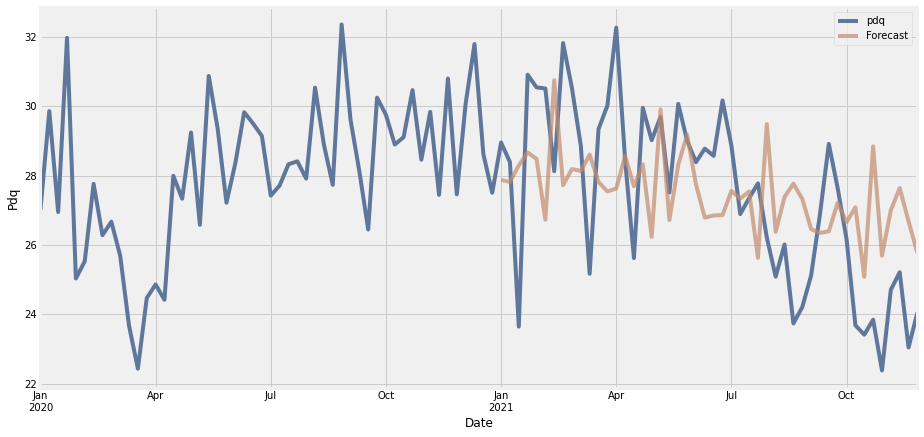

In [ ]:
#grafica del mejor modelo

preds = best_model['yhat']
ax = y_s4['2020':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Pdq')
plt.legend()
plt.show()

En este caso, el mejor modelo encontrado no se ajusta muy bien a los datos de test.

Ahora veamos algunos resultados asociados al error del modelo

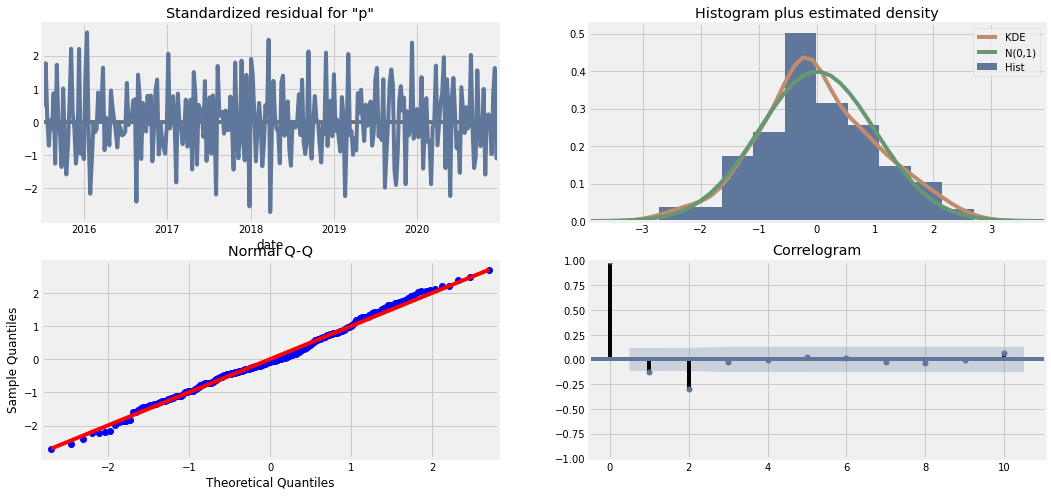

In [ ]:
# resultados del error 
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

Gracias al grafico de standarized residual se logra ver que la nueva serie de tiempo corresponde a una serie estacionaria que oscila entorno al cero, es decir, un ruido blanco.

Gracias al histograma plus estimated density se logra ver que el histograma del error. En este caso, el histograma es muy similar al histograma de una variable N(0,1).

Gacias al grafico de normal Q-Q se logra ver que la distribucion del error tiene un ajuste lineal, lo cual indica que la distribución entre la muestra obtenida y la distribución de prueba son muy parecias, es decir, una distribución normal.

Gracias al correlograma podemos ver la autocorrelación entre las variables del error y se observa que no hay correlación entre ninguna de las variables, por lo que se puedan dar indicios de independencia entre las variables.

Gracias a los resultados obtendios por estso s graficos, poedmos decir que el error asociado al modelo en estudio corresponde a un ruido blanco.

3. Resuelva el ejercicio anterior utilizando la librería de `Prophet`.

In [ ]:
from prophet import Prophet

mask_ds = y_s2.index < target_date
y_train = y_s2[mask_ds]
y_test = y_s2[~mask_ds]

# renombrar los datos de y_train, y_test
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ["ds","y"]

y_test_prophet = y_test.reset_index()
y_test_prophet.columns = ["ds","y"]

In [ ]:
# modelo
prophet = Prophet()
prophet.fit(y_train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9vzh2w8r/8299py6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9vzh2w8r/xn778a_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72624', 'data', 'file=/tmp/tmp9vzh2w8r/8299py6a.json', 'init=/tmp/tmp9vzh2w8r/xn778a_j.json', 'output', 'file=/tmp/tmp9vzh2w8r/prophet_modell4ndr0vi/prophet_model-20221110231441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# forecast
future = prophet.make_future_dataframe(periods=365*4)
forecast = prophet.predict(future)[['ds', 'yhat']]
forecast.tail()

,ds,yhat
1768,2024-12-22,28.216933
1769,2024-12-23,28.230594
1770,2024-12-24,28.252182
1771,2024-12-25,28.281099
1772,2024-12-26,28.316603


In [ ]:
# metricas
result = y_test_prophet.merge(forecast,on = 'ds',how='inner')
summary_metrics(result)

,mae,mse,rmse,mape,maape,wmape,mmape,smape
0,1.2731,2.9623,1.7211,0.0447,0.0446,0.0459,0.0432,0.0456


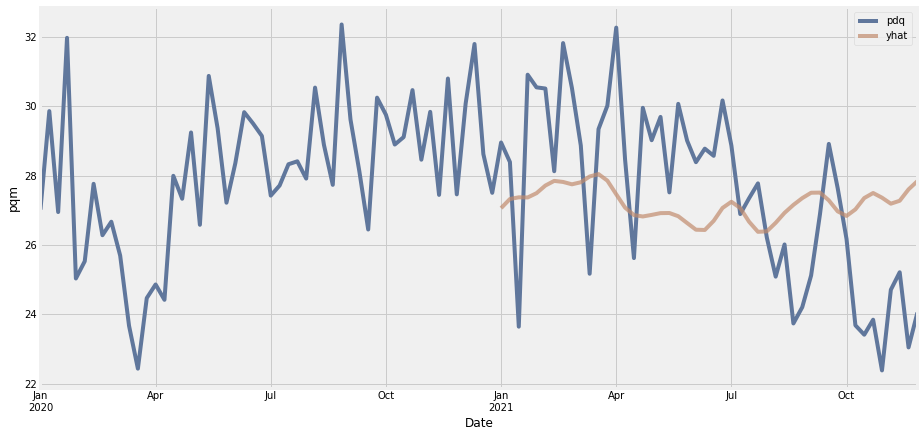

In [ ]:
preds = result[['ds','yhat']].set_index("ds")
ax = y_s4['2020':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('pqm')
plt.legend()
plt.show()

Al usar Prophet se obtiene una curva más suave que la obtenida por el metodo Sarima con los mejores hiperparametros; además, comparando el ajuste de esta nueva curva con los datos del conjuntos test, seria menor. Por otro lado, comparando los resultados de las metricos del metodo Sarima con los mejores hiperparametros y el modelo Prophet, se tiene que Prophet es mejor usando esta caracteristica pues son menores al metodo Sarima.